## 12-31-2025

# Module 2: Feature Extraction

**Purpose:**
Extract multi-modal features from BAM files for classification with high-resolution genomic binning.

**Features Extracted:**
1. **Fragment size features** - distributions, summary stats, size bins (20 features)
2. **Position features** - start/end positions with **500 bp bins** across chr21 (~93,420 bins)
3. **End motif features** - 4-mer frequencies from fragment ends (258 features)
4. **Global methylation features** - CpG rates, variance, per-read stats (10 features)
5. **Regional methylation features** - CpG methylation with **500 bp bins** (~93,420 bins)

**Binning Strategy:**
- **Bin size:** 500 bp (nucleosome-level resolution)
- **Number of bins:** Calculated dynamically from chromosome length (~93,420 for chr21)
- **Min CpG per bin:** 3 sites

**Inputs:**
- `data/processed/sample_manifest.csv` (from Module 0)
- BAM files

**Outputs:**
- `data/processed/all_features.csv` (~187,000 features × 22 samples, ~140 MB file)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import Module 2 functions
from src.feature_extraction import (
    get_chromosome_length,
    extract_fragment_features,
    extract_position_features,
    extract_motif_features,
    extract_methylation_features,
    extract_regional_methylation,
    extract_all_features_from_bam,
    run_module_2
)

# Import config
from src.config import (
    SAMPLE_MANIFEST,
    ALL_FEATURES,
    CHROMOSOME,
    POSITION_BIN_SIZE,
    METHYLATION_BIN_SIZE,
    MIN_CPG_PER_BIN
)

print("✓ Imports successful!")
print(f"\nConfiguration:")
print(f"  Chromosome: {CHROMOSOME}")
print(f"  Position bin size: {POSITION_BIN_SIZE:,} bp")
print(f"  Methylation bin size: {METHYLATION_BIN_SIZE:,} bp")
print(f"  Min CpG per bin: {MIN_CPG_PER_BIN}")

✓ Imports successful!

Configuration:
  Chromosome: chr21
  Position bin size: 500 bp
  Methylation bin size: 500 bp
  Min CpG per bin: 3


In [2]:
# Load manifest to get first BAM file
manifest = pd.read_csv(SAMPLE_MANIFEST)
first_bam = manifest.iloc[0]['bam_path']

# Get chromosome length
import math
chr_length = get_chromosome_length(first_bam, CHROMOSOME)

# Calculate expected bins
n_pos_bins = math.ceil(chr_length / POSITION_BIN_SIZE)
n_meth_bins = math.ceil(chr_length / METHYLATION_BIN_SIZE)

print(f"Chromosome {CHROMOSOME} length: {chr_length:,} bp")
print(f"\nExpected bins:")
print(f"  Position bins: {n_pos_bins:,} bins")
print(f"  Methylation bins: {n_meth_bins:,} bins")
print(f"\nExpected total features: ~{20 + n_pos_bins + 258 + 10 + n_meth_bins:,}")

Chromosome chr21 length: 46,709,983 bp

Expected bins:
  Position bins: 93,420 bins
  Methylation bins: 93,420 bins

Expected total features: ~187,128


## Option 1: Quick Run - Execute Complete Module 2

Extract all features from all 22 samples at once.

In [3]:
# Run complete Module 2 pipeline
features_df = run_module_2()


MODULE 2: Feature Extraction

Loading sample manifest from: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/sample_manifest.csv
✓ Loaded manifest: 22 samples

Binning configuration:
  Chromosome: chr21
  Chromosome length: 46,709,983 bp
  Position bin size: 500 bp → 93,420 bins
  Methylation bin size: 500 bp → 93,420 bins
  Minimum CpG per bin: 3

Extracting features from all samples...


Processing samples: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:03<00:00,  2.88s/it]



✓ Feature extraction complete
  Samples: 22
  Total columns: 280566
  Total features: 280562

Feature breakdown:
  Fragment size features: 17
  Position bin features: 93421
  Motif features: 259
  Global methylation features: 12
  Regional methylation features: 93421
  Total: 187130

Regional methylation coverage:
  Mean bins with data: 11885 / 93420
  Min bins with data: 9959
  Max bins with data: 12593
  Average coverage: 12.7%

✓ Saved all features to: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/all_features.csv
  File size: 34.2 MB

MODULE 2 COMPLETE



## Examine Feature Matrix

Check extracted features:

In [4]:
# Display shape
print(f"Feature matrix shape: {features_df.shape}")
print(f"  Samples: {features_df.shape[0]}")
print(f"  Total columns: {features_df.shape[1]:,}")
print(f"  Features (excluding metadata): {features_df.shape[1] - 4:,}")

# Memory usage
memory_mb = features_df.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"\nMemory usage: {memory_mb:.1f} MB")

# Show metadata
print(f"\nSample distribution:")
print(features_df.groupby(['disease_status', 'batch']).size().unstack(fill_value=0))

# Display first few rows (metadata only)
features_df[['sample_id', 'disease_status', 'batch', 'age']].head()

Feature matrix shape: (22, 280566)
  Samples: 22
  Total columns: 280,566
  Features (excluding metadata): 280,562

Memory usage: 47.1 MB

Sample distribution:
batch           discovery  validation
disease_status                       
als                     4           8
ctrl                    4           6


,sample_id,disease_status,batch,age
0,SRR13404367,als,discovery,61
1,SRR13404368,als,discovery,57
2,SRR13404369,als,discovery,85
3,SRR13404370,als,discovery,63
4,SRR13404371,ctrl,discovery,60


In [5]:
# Count features by type
feature_types = {
    'Fragment': [c for c in features_df.columns if c.startswith('frag_') or c == 'n_fragments'],
    'Position bins': [c for c in features_df.columns if c.startswith('pos_bin_')],
    'Position metadata': [c for c in features_df.columns if c.startswith('pos_') and not c.startswith('pos_bin_')],
    'Motif': [c for c in features_df.columns if c.startswith('motif_') or c == 'n_motifs'],
    'Global methylation': [c for c in features_df.columns if c.startswith('meth_') and 'meth_bin_' not in c and not c.endswith('_n_cpg')],
    'Regional methylation bins': [c for c in features_df.columns if c.startswith('meth_bin_') and not c.endswith('_n_cpg')],
    'Methylation bin QC': [c for c in features_df.columns if c.endswith('_n_cpg')],
    'Metadata': ['sample_id', 'disease_status', 'batch', 'age']
}

print("Feature Breakdown:")
print("=" * 60)
for feat_type, cols in feature_types.items():
    print(f"{feat_type:30s}: {len(cols):6,} features")

print(f"\n{'Total':30s}: {sum(len(cols) for cols in feature_types.values()):6,} columns")

Feature Breakdown:
Fragment                      :     17 features
Position bins                 : 93,421 features
Position metadata             :      6 features
Motif                         :    259 features
Global methylation            :     12 features
Regional methylation bins     : 93,421 features
Methylation bin QC            : 93,420 features
Metadata                      :      4 features

Total                         : 280,560 columns


## Regional Methylation Coverage Check

With 500 bp bins and downsampled data, many bins may have insufficient CpG coverage.

Let's check how many bins have data:

Regional Methylation Coverage:

Total methylation bins: 93,420

Bins with data per sample (≥3 CpG sites):
count       22.000000
mean     11884.863636
std        600.312323
min       9959.000000
25%      11723.250000
50%      11952.500000
75%      12271.750000
max      12593.000000
Name: n_bins_with_data, dtype: float64

Coverage percentage:
count    22.000000
mean     12.721969
std       0.642595
min      10.660458
25%      12.548972
50%      12.794370
75%      13.136106
max      13.479983
Name: coverage_pct, dtype: float64


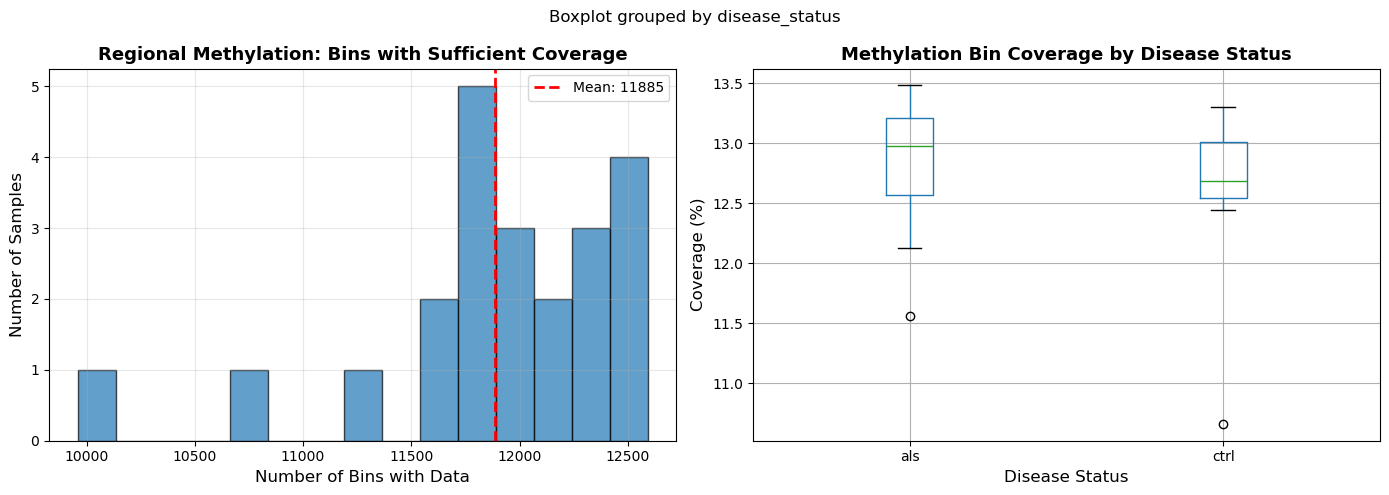


Coverage by disease status:
  ALS: 12.8% ± 0.6%
  Control: 12.6% ± 0.7%
  Mann-Whitney p-value: 0.2485
  ✓ Coverage is similar between groups


In [6]:
# Check coverage across samples
if 'n_bins_with_data' in features_df.columns:
    print("Regional Methylation Coverage:")
    print("=" * 60)
    print(f"\nTotal methylation bins: {n_meth_bins:,}")
    print(f"\nBins with data per sample (≥{MIN_CPG_PER_BIN} CpG sites):")
    print(features_df['n_bins_with_data'].describe())
    
    # Calculate coverage percentage
    features_df['coverage_pct'] = (features_df['n_bins_with_data'] / n_meth_bins) * 100
    
    print(f"\nCoverage percentage:")
    print(features_df['coverage_pct'].describe())
    
    # Visualize coverage
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of bins with data
    ax = axes[0]
    features_df['n_bins_with_data'].hist(bins=15, ax=ax, edgecolor='black', alpha=0.7)
    ax.axvline(features_df['n_bins_with_data'].mean(), color='red', linestyle='--', 
              linewidth=2, label=f'Mean: {features_df["n_bins_with_data"].mean():.0f}')
    ax.set_xlabel('Number of Bins with Data', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Regional Methylation: Bins with Sufficient Coverage', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Coverage by disease status
    ax = axes[1]
    features_df.boxplot(column='coverage_pct', by='disease_status', ax=ax)
    ax.set_xlabel('Disease Status', fontsize=12)
    ax.set_ylabel('Coverage (%)', fontsize=12)
    ax.set_title('Methylation Bin Coverage by Disease Status', fontsize=13, fontweight='bold')
    plt.sca(ax)
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Check if coverage differs by disease
    from scipy.stats import mannwhitneyu
    als_cov = features_df[features_df['disease_status'] == 'als']['coverage_pct']
    ctrl_cov = features_df[features_df['disease_status'] == 'ctrl']['coverage_pct']
    stat, p_val = mannwhitneyu(als_cov, ctrl_cov)
    
    print(f"\nCoverage by disease status:")
    print(f"  ALS: {als_cov.mean():.1f}% ± {als_cov.std():.1f}%")
    print(f"  Control: {ctrl_cov.mean():.1f}% ± {ctrl_cov.std():.1f}%")
    print(f"  Mann-Whitney p-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print("  ⚠️  Coverage differs significantly between groups!")
    else:
        print("  ✓ Coverage is similar between groups")

## Check for Missing Data

With high-resolution binning, we expect many NaN values in bins with low coverage:

In [7]:
# Count NaN values
print("Missing Data Summary:")
print("=" * 60)

# Overall NaN count
total_values = features_df.shape[0] * features_df.shape[1]
nan_count = features_df.isna().sum().sum()
nan_pct = (nan_count / total_values) * 100

print(f"Total values: {total_values:,}")
print(f"NaN values: {nan_count:,} ({nan_pct:.1f}%)")

# NaN by feature type
print(f"\nNaN values by feature type:")

for feat_type, cols in feature_types.items():
    if len(cols) > 0:
        type_nans = features_df[cols].isna().sum().sum()
        type_total = len(cols) * len(features_df)
        type_pct = (type_nans / type_total) * 100 if type_total > 0 else 0
        print(f"  {feat_type:30s}: {type_pct:5.1f}% NaN")

# Samples with most NaNs
sample_nan_counts = features_df.isna().sum(axis=1)
print(f"\nSamples with most NaN values:")
worst_samples = features_df[['sample_id', 'disease_status', 'batch']].copy()
worst_samples['nan_count'] = sample_nan_counts
worst_samples['nan_pct'] = (sample_nan_counts / len(features_df.columns)) * 100
print(worst_samples.sort_values('nan_count', ascending=False).head(10).to_string(index=False))

Missing Data Summary:
Total values: 6,172,474
NaN values: 1,793,773 (29.1%)

NaN values by feature type:
  Fragment                      :   0.0% NaN
  Position bins                 :   0.0% NaN
  Position metadata             :   0.0% NaN
  Motif                         :   0.0% NaN
  Global methylation            :   0.0% NaN
  Regional methylation bins     :  87.3% NaN
  Methylation bin QC            :   0.0% NaN
  Metadata                      :   0.0% NaN

Samples with most NaN values:
  sample_id disease_status      batch  nan_count   nan_pct
SRR13404383           ctrl validation      83461 29.747262
SRR13404375            als validation      82625 29.449294
SRR13404380            als validation      82089 29.258252
SRR13404371           ctrl  discovery      81797 29.154177
SRR13404386           ctrl validation      81709 29.122812
SRR13404379            als validation      81702 29.120317
SRR13404384           ctrl validation      81681 29.112832
SRR13404377            als valid

Regional Methylation Coverage by Disease Status:

Coverage by disease status:
                count       mean       std        min        25%        50%  \
disease_status                                                                
als              12.0  12.834552  0.564764  11.556288  12.570782  12.977810   
ctrl             10.0  12.588925  0.732855  10.661414  12.544289  12.680768   

                      75%        max  
disease_status                        
als             13.206345  13.480909  
ctrl            13.007247  13.297867  

Mann-Whitney U test:
  ALS: 12.83% ± 0.56%
  Control: 12.59% ± 0.73%
  p-value: 0.2485

✓ Coverage is balanced between ALS and Control (p > 0.05)
  NaN patterns are not biased by disease status


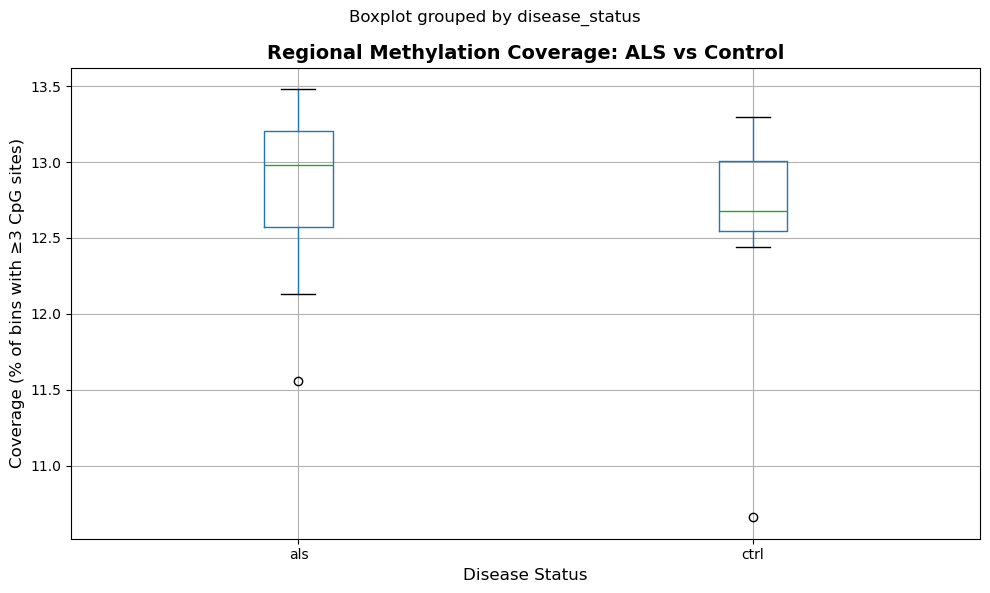

In [9]:
print("Regional Methylation Coverage by Disease Status:")
print("=" * 70)

# Calculate bins with data per sample
meth_bin_cols = [c for c in features_df.columns if c.startswith('meth_bin_') and not c.endswith('_n_cpg')]

features_df['n_meth_bins_with_data'] = features_df[meth_bin_cols].notna().sum(axis=1)
features_df['meth_coverage_pct'] = (features_df['n_meth_bins_with_data'] / len(meth_bin_cols)) * 100

# Group by disease
coverage_summary = features_df.groupby('disease_status')['meth_coverage_pct'].describe()
print("\nCoverage by disease status:")
print(coverage_summary)

# Statistical test
from scipy.stats import mannwhitneyu

als_cov = features_df[features_df['disease_status'] == 'als']['meth_coverage_pct']
ctrl_cov = features_df[features_df['disease_status'] == 'ctrl']['meth_coverage_pct']

stat, p_val = mannwhitneyu(als_cov, ctrl_cov)

print(f"\nMann-Whitney U test:")
print(f"  ALS: {als_cov.mean():.2f}% ± {als_cov.std():.2f}%")
print(f"  Control: {ctrl_cov.mean():.2f}% ± {ctrl_cov.std():.2f}%")
print(f"  p-value: {p_val:.4f}")

if p_val > 0.05:
    print("\n✓ Coverage is balanced between ALS and Control (p > 0.05)")
    print("  NaN patterns are not biased by disease status")
else:
    print("\n⚠️ Coverage differs between groups - potential bias!")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
features_df.boxplot(column='meth_coverage_pct', by='disease_status', ax=ax)
ax.set_title('Regional Methylation Coverage: ALS vs Control', fontsize=14, fontweight='bold')
ax.set_xlabel('Disease Status', fontsize=12)
ax.set_ylabel('Coverage (% of bins with ≥3 CpG sites)', fontsize=12)
plt.sca(ax)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Visualize Regional Methylation Profile

Plot methylation across chr21 for one sample: